## Sequência de funções valor para os credores

Queremos resolver por indução retroativa um jogo com T períodos.

Estou trabalhando em como deixar esse jogo em torno do parâmetro T

Teremos duas sequências de funções valor: uma para quando apenas o credor sênior propõe e outra para quando apenas o credor júnior propõe. As funções do jogo final serão uma média ponderada destas.



In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
#libraries
import numpy as np
from numba import jit, jitclass, float64, njit
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from scipy.stats import beta

import math

In [30]:
#parâmetros do jogo, apenas para ilustração a princípio



μ = 3 #número de meses entre períodos, não entendi onde entra ainda
ρ = 0.9 # (1 - ρ) é a taxa de depreciação da empresa a cada período
Β = 1 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c_0 = 5 #custo fixo de ir para a corte


λj = 0.5 #probabilidade de j propor a cada turno. Não precisaremos estimar, isso virá dos dados


h_s0 = 0.5 #habilidade inicial de s
h_j0 = 0.5 #habilidade inicial de j

In [32]:
#informações que virão dos dados

Vmax = 100
L = 20 
L_s = 10
L_j = 10

### Qual a estratégia ótima de s no jogo onde apenas ele propõe?

Ele decide em qual período reorganizar a firma. Então, ao invés da estratégia threshold, vou propor uma outra solução.

A cada período k, o credor sênior olhará a sua habilidade $\theta_{s,k}$ e fará estimativas do seu ganho nos seguintes cenários:

1. O que acontece se ele propor reorganizar já no período k?

2. O que acontece se ele propor reorganizar já no período k+1?

3. (...) 

4. O que acontece se ele propor reorganizar no penúltimo período?

5. O que acontece se ele não propuser reorganizar, ou seja, se receber o valor de liquidação final L_s?

Caso o ganho de propor reorganizar já no período k seja o maior, ele propõe pagar $L_j$ para que o adversário aceite. E caso contrário, ele faz uma proposta inferior a isto com o intuito de adiantar o jogo para o próximo período (proposta de esperar).

#### Qual era o problema com estratégias threshold? 

Alguns thresholds estavam se sobrepondo, então em um mesmo período a política ótima recomendava ao mesmo tempo propor reorganizar a firma e propor esperar.

Por exemplo, na figura abaixo nós não sabemos o que aconteceria se a habilidade do jogador caisse entre as duas linhas. Ele ficar abaixo da linha azul significa que a jogada ótima é esperar. E ficar acima da linha laranjada significa que a jogada ótima é reorganizar. Assim, a sobreposição de thresholds não permite que montemos uma função política.

### Gráfico dos thresholds

Text(0.5, 0, 'pontos entre 0 e 1')

Text(0, 0.5, 'threshold')

Text(0.5, 0.98, 'Thresholds de reorganização variando para ρ entre 0 e 1')

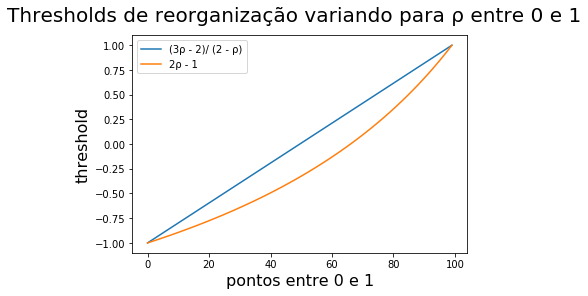

In [29]:
#gráfico dos primeiros thresholds do modelo


f = lambda x: (3*x-2)/(2-x)
g = lambda x: 2*x-1

x = np.linspace(0, 1, 100)
   
fig, ax = plt.subplots()

plt.plot(g(x), label = '(3ρ - 2)/ (2 - ρ)')
plt.plot(f(x), label = "2ρ - 1" )
plt.xlabel('pontos entre 0 e 1', fontsize=16)
plt.ylabel('threshold', fontsize=16)
fig.suptitle('Thresholds de reorganização variando para ρ entre 0 e 1', fontsize=20)
plt.legend()
plt.show()

#parece que o threshold 'baixo' é sempre maior que o alto. Esquisito isso, não sei como vai implicar a realização do modelo

### Qual o ganho que o credor s tem em propor a cada período?

Suponha que ele vai propor reorganizar a firma no perído t. A reorganização demora 1 período, então o valor da firma aparece no próximo período, $V_{t+1}$. E ele precisa fazer uma estimativa sobre $\theta_{s,t+1}$ dada a informação que ele tem no período atual, que eu chamei de k: $\theta_{s,k}$:

$$ R_t (\theta_{s,k}) = V_{t+1} \bigg( \mathbb{E}_k^s \big[ \theta_{s,t+1} \mid \theta_{s,k} \big] \bigg) - L_j$$


#### Qual a estimativa da habilidade dele nos períodos à frente dada a informação dele hoje?

Essa parte depende da hipótese sobre a distribuição da habilidade.

Se supormos que a habilidade segue distribuição Uniforme, a forma fechada dela é:

Suponha $ t > k$

$$ \mathbb{E}_k^s \big[ \theta_{s,t} \mid \theta_{s,k} \big] =  \frac{\theta_{s,k}} {2^{t - k}} + \sum_{n=1}^{t - k} \frac{1}{2^{n}} $$


#### Quais os passos do algoritmo para implementar essa estratégia?

1. Calcular todos os valores de reorganização $ R_t $ de $ t \in  \{k, k+1, ..., T\}$ e também o valor de nunca reorganizar, que é $L_s$

2. Criar uma condição para checar se $\max \{R_{k}, R_{k+1}, ..., R_{T}, L_s \} = R_{k}$
    * em caso positivo, oferecer $P_s = W_{j, t+1} = L_j$ a fim de reorganizar a firma
    * em caso negativo, oferecer $P_s < W_{j, t+1} = L_j$ a fim de adiantar o jogo até o próximo período
    
3. Repetir os passos 1 e 2 até que reorganize a firma ou o jogo termine com ela liquidada

In [1]:
#função para calcular a esperança da habilidade nos períodos à frente
def expec(h, k, t):
    #h é a habilidade hoje, usada como informação
    #k é o período de hoje
    #t é o período para o qual eu desejo estimar a habilidade
    
    #somatório de n até t-k
    summation = 0
    for i in range(1, t-k+1):      
        summation += 2**-i
    
    resultado = h/2**(t-k) + summation
    
    return resultado
    
# expec(0.5, 1, 4) #ok com os meus cálculos

#como ficaria um gráfico dessa função?


In [8]:
#função para calcular o valor de reorganizar a empresa t períodos à frente

#coloquei V[t] porque ele já pega t+1, considerando que o python conta a partir do zero

def reorg(h, k, t):
    return V[t] * expec(h,k,t+1) - L_j 




### Chegamos à estratégia.

Como R[0] significa hoje, se o argmax de R for hoje, então a estratégia ótima é jogar Ps = L_j. Do contrário, vou supor que a oferta é menor que isso (será que tem diferença colocar Ps = 0 ou só Ps = L_j - 1?


In [13]:
#agora chegamos à estratégia...



if np.argmax(R) == 0:
    P_s = L_j
    print("Propõe Reorganizar")

else:
    P_s = L_j - 1
    print("Propõe Esperar")
            


Propõe Esperar


## Juntando tudo
Agora vamos juntar tudo num loop sobre o tempo. A cada período:

1. O credor s recebe sua habilidade $\theta_{s,t}$; 

2. Calcula todos os payoffs futuros esperados de reorganizar ou não

3. Decide a política ótima

In [114]:
#retirada da habilidade de s
#é uma função da habilidade dele no período passado

#vetor com as habilidade realizadas em cada período
H_s = []
h_s0 = 0.1
H_s.append(h_s0)

#habilidade hoje é h_s, habilidade ontem é h_s1

h_s1 = H_s[len(H_s) -1]
def draw(x):
    h_s = np.random.uniform(x, 1)
    
    H_s.append(h_s) #atualiza com a habilidade realizada
    return h_s



### Solução do modelo simples

In [506]:
#código para computar em qual período s reorganiza a firma

def pbe(max_turnos, h_s0):
    
    #max_turnos vai ser calculada a partir de V, ρ e L. Por enquanto fica assim
    #max_turnos = 4 é o que estou testando
    #h_s0 é o nível de habilidade inicial do credor s
    t = 1
    
    
    
    #vetor que conterá as habilidades
    H_s = []
#     h_s0 = 0.1 #agora h_s0 é argumento da função
    H_s.append(h_s0)


    
    #vetor com os valores estimados de reorganização
    R = np.ones(max_turnos)
    R[0] = 0
    
    
    #faz um loop até que o valor máximo de reorganizar seja o de propor reorganizar em t
    while t < max_turnos and np.argmax(R) > 0:
        
        h_s = draw(h_s1)
    
        #matriz dos payoffs de reorganizar a firma
        R = np.empty(T-t + 1)


        # a última entrada de R é sempre o valor de liquidação
        R[len(R) -1] = L_s

        for i in range(t, T-t+1):
            R[i-t] = reorg(h_s, t, i)
        
        t = t + 1
    #retorna um vetor com três elementos: o período, a habilidade e o valor de Reorganização da firma
    return t, h_s, R[0]
    
    
    

In [450]:
pbe(4, 0.1)

(2, 0.6776671069483801, 65.4950198126771)

### Estática Comparativa

Gráfico para mostrar como o valor de reorganização muda de acordo com a habilidade inicial do jogador s

Text(0.5, 1.0, 'Valor de Reorganização em relação à habilidade inicial')

Text(0.5, 0, 'Valor de Reorganização')

Text(0, 0.5, 'Habilidade Inicial')

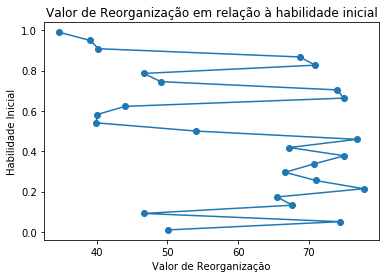

In [505]:
#gráfico para estática comparativa
grid_size = 25
H = np.empty(grid_size)

h_s0_vals = np.linspace(0.01, 0.99, grid_size)


R_vals = np.empty(grid_size)

for i in range(grid_size):
    R_vals[i] = pbe(4, h_s0_vals[i])[2]



fig, ax = plt.subplots()
ax.plot(R_vals, h_s0_vals, '-o', label='$q(w(i))$')
ax.set_title("Valor de Reorganização em relação à habilidade inicial")
ax.set_xlabel('Valor de Reorganização')
ax.set_ylabel('Habilidade Inicial')

plt.show()

#o valor de reorganização não é crescente na habilidade inicial.
#Acho que é por causa da aleatoriedade, então vou calcular a MÈDIA do valor de reorganização para vários draws com a mesma h_s0

# Próximos passos



* na função pbe
    * colocar o vetor V dentro do loop também
    * substituis max_turnos por V, L e \rho
    * fazer o gráfico da média do valor de reorganização
    
* colocar o valor de liquidação do jogador a cada período
    * resolver o jogo onde ele tem a opção de liquidar, mas é o único a propor
    
* começar a trabalhar nas funções valor finais


* passos finais
    * replicar os gráficos do artigo de referência
